<a href="https://colab.research.google.com/github/farghea/Pose-Detection-Biomechanics/blob/main/repetitive_lifting_metras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
import cv2
import numpy as np

# Delete "frames" directory with all files in it if it exists and create a new "frames" directory
video_file = "/content/drive/MyDrive/integrating new tech/validation/repetative lifting/rep_lift.MOV"
output_dir = "frames"

if os.path.exists(output_dir):
    !rm -rf {output_dir}
os.makedirs(output_dir)

# Read the video file
cap = cv2.VideoCapture(video_file)

# Get the video's frame rate
frame_rate = cap.get(cv2.CAP_PROP_FPS)

# Frame numbers to skip
Frame_numbers_to_skip = 10

frame_number = 0
output_frame_number = 0

# Create an array to store the time corresponding to each saved frame
frame_times = []

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Break the loop if we've reached the end of the video
    if not ret:
        break

    # Skip each 10 frames
    if frame_number % Frame_numbers_to_skip == 0:
        # Rotate the frame 90 degrees counter-clockwise
        # rotated_frame = cv2.rotate(frame, cv2.ROTATE_0_CLOCKWISE)

        # Save the frame as a JPG file
        output_path = os.path.join(output_dir, f"frame{output_frame_number:d}.jpg")
        cv2.imwrite(output_path, frame)

        # Calculate the time corresponding to this frame and append it to the array
        frame_time = frame_number / frame_rate
        frame_times.append(frame_time)

        output_frame_number += 1
        print(output_frame_number)

    frame_number += 1


# Release the video file
cap.release()

print(f"Processed {output_frame_number} frames and saved them in the '{output_dir}' directory.")

# Convert the frame_times array to a numpy array
frame_times = np.array(frame_times)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes

joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()


In [ ]:
import numpy as np

landmark_info = {
      'hip': [1, 2],
      'shoulder': [16, 17],
      'knee': [4, 5],
      'hand': [22, 23]}

def cal_mid_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  mid_point = 0.5*(pnt1 + pnt2)
  return mid_point

def estimate_3D_pose(jpg_file_name):
  myimg = tf.image.decode_image(tf.io.read_file(jpg_file_name))
  mypred = model.detect_poses(myimg, skeleton='smpl+head_30')

  pred_pose = mypred['poses3d'].numpy().reshape((30, 3))

  # lambda function to normalize a vector
  normalize = lambda vec: vec / np.linalg.norm(vec)

  # mid hip
  mid_hip = cal_mid_point('hip', pred_pose)

  # mid knee
  mid_knee = cal_mid_point('knee', pred_pose)

  # mid shoulder
  mid_shoulder = cal_mid_point('shoulder', pred_pose)

  # mid hand
  mid_hand = cal_mid_point('hand', pred_pose)

  # Shoulder length
  pnt1 = pred_pose[16, :]
  pnt2 = pred_pose[17, :]
  shoulder_length = np.linalg.norm(pnt2 - pnt1)

  # Flexion angle
  v1 = normalize(mid_shoulder - mid_hip)
  v2_org = normalize(mid_hip - mid_knee)
  v2 = np.array([0, -1, 0])
  flexion_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # hand to mid-hip distance (normalized to the shoulder distance)
  mid_hip_to_hand_distance = np.linalg.norm(mid_hand - mid_hip)/shoulder_length

  return flexion_angle, mid_hip_to_hand_distance, v1, v2_org, v2


In [ ]:

def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(0, 90)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(2000, 5000)

    pose_ax.set_xlabel('x')
    pose_ax.set_ylabel('y')
    pose_ax.set_zlabel('z')

    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)



In [ ]:
analysis_results = {
    'time':   [],
    'flex_pose':   [],
    'dist_pose':    []}


for i in range(output_frame_number):
  print(f'{i} out of {output_frame_number}')
  myfile = f'/content/frames/frame{i:d}.jpg'
  pose_estimation_parameters = estimate_3D_pose(myfile)

  analysis_results['time'].append(frame_times[i])
  analysis_results['flex_pose'].append(pose_estimation_parameters[0])
  analysis_results['dist_pose'].append(pose_estimation_parameters[1])


In [ ]:
import shutil
import pandas as pd

df = pd.DataFrame(analysis_results)
file_name = 'analyzed_results_metras2023_repetitive_lifting.csv'

df.to_csv(file_name)

destination_dir = '/content/drive/MyDrive/integrating new tech/validation'
destination_file = os.path.join(destination_dir, file_name)

if os.path.exists(destination_file):
    os.remove(destination_file)

shutil.move(file_name, destination_dir)


'/content/drive/MyDrive/integrating new tech/validation/analyzed_results_metras2023_repetitive_lifting.csv'

In [ ]:
# Get estimated data from the file
file_path = os.path.join(destination_dir, file_name)
estimated_posture = pd.read_csv(file_path)

print(estimated_posture)


     Unnamed: 0        time  flex_pose  dist_pose
0             0    0.000000   7.285130   1.436719
1             1    0.333574   5.894782   1.918503
2             2    0.667147   4.953375   2.638242
3             3    1.000721   6.525551   2.887024
4             4    1.334294   7.494126   2.816642
..          ...         ...        ...        ...
648         648  216.155658   4.085620   1.582022
649         649  216.489231   2.576634   2.045489
650         650  216.822805   2.716565   2.759959
651         651  217.156378   5.495117   2.893047
652         652  217.489952   5.478938   2.744197

[653 rows x 4 columns]


In [ ]:
# Get experimental data
experiment_data = pd.read_excel(f'/content/drive/MyDrive/integrating new tech/validation/repetative lifting/exp_repetetive_lifting.xlsx')
time_shift_to_sync = 2.0014

experiment_data['time'] = experiment_data['time'] + time_shift_to_sync

print(experiment_data)


          time     theta
0       2.0014 -4.716038
1       2.0214 -4.723479
2       2.0414 -4.746595
3       2.0614 -4.788182
4       2.0814 -4.842878
...        ...       ...
8690  175.8014  2.036795
8691  175.8214  1.996615
8692  175.8414  1.962855
8693  175.8614  1.923242
8694  175.8814  1.873609

[8695 rows x 2 columns]


In [ ]:
# Sync data
import numpy as np

end_time = np.min([estimated_posture['time'].iloc[-1], experiment_data['time'].iloc[-1]])
start_time = np.max([estimated_posture['time'].iloc[0], experiment_data['time'].iloc[0]])

dt_exp = experiment_data['time'].iloc[1]-experiment_data['time'].iloc[0]
dt_est = estimated_posture['time'].iloc[1] - estimated_posture['time'].iloc[0]

# Sync both data
if (dt_est) > (dt_exp):
  sync_time = np.arange(start_time, end_time, dt_exp)
else:
  sync_time = np.arange(start_time, end_time, dt_est)

sync_theta_exp = np.interp(sync_time, experiment_data['time'].to_numpy(), experiment_data['theta'].to_numpy())
sync_theta_est = np.interp(sync_time, estimated_posture['time'].to_numpy(), estimated_posture['flex_pose'].to_numpy())


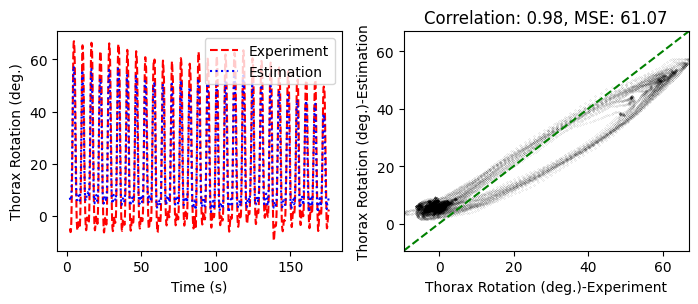

In [ ]:
# Plot data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error


# Set font to Arial and font size to 10
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 10

cm = 2.54
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18/cm, 8/cm))  # 8cm x 6cm = 3.15in x 2.36in

# Plot the data
ax[0].plot(sync_time, sync_theta_exp, '--r', label='Experiment')
ax[0].plot(sync_time, sync_theta_est, ':b', label='Estimation')

# Set the x and y labels
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Thorax Rotation (deg.)')

# Add the legend
ax[0].legend()


# - - - Correlation plot
ax[1].plot(sync_theta_exp, sync_theta_est, 'ok', alpha = 0.6, markersize=0.1)
# ax[1].set_xlabel('Thorax Rotation (deg.) - Experiment')

# Find the min and max values for x and y axes
min_val = min(min(sync_theta_exp), min(sync_theta_est))
max_val = max(max(sync_theta_exp), max(sync_theta_est))

# Add the unity line (y = x) to the plot
ax[1].plot([min_val, max_val], [min_val, max_val], '--g', label='Unity Line')

# Make ranges in x and y axes equal
ax[1].set_xlim([min_val, max_val])
ax[1].set_ylim([min_val, max_val])

# Calculate the correlation
correlation = np.corrcoef(sync_theta_exp, sync_theta_est)[0, 1]

# Calculate the mean squared error
mse = mean_squared_error(sync_theta_exp, sync_theta_est)

# Add the correlation and MSE to the title of the second plot
ax[1].set_title(f"Correlation: {correlation:.2f}, MSE: {mse:.2f}")

# Axis labels
ax[1].set_xlabel('Thorax Rotation (deg.)-Experiment')
ax[1].set_ylabel('Thorax Rotation (deg.)-Estimation')

# Display the plot
plt.tight_layout()
plt.show()